
# SAR Application: Biomass
### I. How to create SAR quicklook images of biomass? 

* Useful Products: Coherence; HV, HH, and HV power
* Useful Wavelengths: L
* Instructions to View: HV/HV ratios, RVI Index, Coherence, Pauli decomposition
* How does the user know there is something in the image related to biomass before they develop/implement any algorithms? 
Vegetation structure

### II. How to interpret SAR images of biomass?

HV backscatter captures the volume contribution and increases with biomass. HV images show where the radar transmitted a horizontally polarized signal (H) and received back a vertically polarized signal (V). This depolarization occurs over vegetation as the radar signal experiences volume scattering off the branches, trunks, and leaves in the canopy. As a result, HV backscatter intensity is higher over vegetation and lower over smoother, less complex surfaces such as bare ground and more sparsely vegetated areas. 

L-band signal saturates at about 150 Mg/ha so it is appropriate for quantifying regeneration. In high-biomass areas, SAR can be used in conjunction with other instruments such as Lidar. 

## SAR Example: 2009 Station Fire

This example explores L-Band UAVSAR data over the 2009 Station Fire in the San Gabriel Mountains in Los Angeles, California. The Station Fire burned over 160,000 acres in the Los Angeles National Forest from August to October 2009. 

UAVSAR is an L-Band airborne radar and has nearly annual data acquistions of the San Gabriel Mountains since 2009. First, we will look at the UAVSAR flightline SanAnd_08525, which encompasses the southern portion of the mountain range. To explore biomass changes following the 2009 station fire, we can calculate the HV/HV ratio (i.e. HV2010/HV2009, HV2012/HV2009, etc.). The HV/HV ratio over time shows the volume ratio increasing as the vegetation recovers after the Station Fire. We will also calculate the Radar Vegetation Index (RVI).

The fire perimeter is also overlaid on the UAVSAR images below to highlight the different growth patterns inside the fire scar. The National Interagency Fire Center hosts current and historic fire perimeters: https://data-nifc.opendata.arcgis.com

The content of this notebook is as follows:

1. [Running the Notebook](#s1)
2. [HV/HV Ratio](#s2)
3. [Radar Vegetation Index (RVI)](#s3)




<a name="s1"></a>
## 1. Running the Notebook

- This Notebook has both "text" and "code" cells. The text cells have text descriptions about running the notebooks and data interpretation.
- Code cells are a light gray and a "play" button appears in the upper left corner when your mouse is hovered over the cell.
- To run the content in the code cells, **select the play button** in the upper left corner of each code cell or **press shift-enter**. 
- Code cells that are required for the notebook to run without errors are marked numerically with <font color='red'> Run cell below </font> 

### Install Python Packages
This routine uses the following python libaries. Some are already included in the Google Colab environment and others are installed with pip by running the cell below. Downloading new python packages to this environment may take a few minutes to complete.

<font color='red'> 1. Run cell below </font> 

In [1]:
!pip install rasterio --quiet
!pip install geopandas --quiet
!pip install rasterstats --quiet

import rasterio as rio
#import rasterio.plot
#from rasterio.plot import show
from rasterio.plot import plotting_extent
import plotly.graph_objects as go
import rasterstats
from rasterstats import zonal_stats
from pathlib import Path

import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import json

import numpy as np
import math

import ipywidgets as wg
from IPython.display import Image

     |████████████████████████████████| 20.9 MB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 4.8 MB/s 
     |████████████████████████████████| 7.8 MB 43.9 MB/s 
     |████████████████████████████████| 16.6 MB 43 kB/s 
     |████████████████████████████████| 139 kB 7.0 MB/s 


### Download the Data

Fetch UAVSAR geotiffs from the download links below with wget. The original UAVSAR data have been converted to cropped and subset geotiffs over the Station Fire perimeter.

<font color='red'> 2. Run cell below </font> 


In [4]:
# Download data files from JPL website
# HV/HV Ratio
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_090918_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_101014_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_121115_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_141023_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_171102_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_181011_HV.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08525_200918_HV.tif --quiet
# RVI 
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_10072_007_101014_L090HHHH_CX_02.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_10072_007_101014_L090HVHV_CX_02.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_10072_007_101014_L090VVVV_CX_02.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_14158_001_141023_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_14158_001_141023_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_14158_001_141023_L090VVVV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_20029_004_201014_L090HHHH_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_20029_004_201014_L090HVHV_CX_01.grd.tif --quiet
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/SanAnd_08527_20029_004_201014_L090VVVV_CX_01.grd.tif --quiet
# Fire Perimeter
!wget https://uavsar.jpl.nasa.gov/SAR_NOTEBOOKS/Biomass/station_fire.geojson --quiet

# Function to read in files
def read_file(path):
    with rio.open(path) as ds:
        band = ds.read(1)
    return band

<a name="s2"></a>
## 2. HV/HV Ratio 

Read in the Station Fire perimeter and the UAVSAR geotiffs and convert the data to decibels (dB). The dB values are less in areas of lower HV backscatter.

### Read in the Data and Convert to dB


<font color='red'> 3. Run cells below </font> 

In [6]:
# Read in UAVSAR Files
HV2009 = read_file('SanAnd_08525_090918_HV.tif')
HV2010 = read_file('SanAnd_08525_101014_HV.tif')
HV2012 = read_file('SanAnd_08525_121115_HV.tif')
HV2014 = read_file('SanAnd_08525_141023_HV.tif')
HV2017 = read_file('SanAnd_08525_171102_HV.tif')
HV2018 = read_file('SanAnd_08525_181011_HV.tif')
HV2020 = read_file('SanAnd_08525_200918_HV.tif')

## Get geographic information from geotiff
with rio.open('SanAnd_08525_090918_HV.tif') as subset_src:
    subset_extent = plotting_extent(subset_src)
    trans = subset_src.transform
## Read in fire shapefile perimeter
fire_boundary = gpd.read_file('station_fire.geojson')
fire_boundary = fire_boundary.to_crs(subset_src.crs)
## specify top left corner lat/lon
top_left_lon = -118.12592154
top_left_lat = 34.31671734
## Specify extent for plotting
extent_mat = (top_left_lon, top_left_lon + subset_src.shape[1] * 0.00005556000000000000337, top_left_lat - subset_src.shape[0] * 0.00005556000000000000337, top_left_lat)

In [7]:
## Convert to decibels (dB)
def convert_db(data):
    db = 10*(math.log10(data))
    return db
converted_db = np.vectorize(convert_db)

HV2009 = converted_db(HV2009)
HV2010 = converted_db(HV2010)
HV2012 = converted_db(HV2012)
HV2014 = converted_db(HV2014)
HV2017 = converted_db(HV2017)
HV2018 = converted_db(HV2018)
HV2020 = converted_db(HV2020)

### Create and Plot HV/HV Ratio

Create the HV/HV ratios and plot each ratio.

Inspecting the (HV acquistions 2010-2020)/(2009 HV acquisition post-fire) ratios, we see the HV/HV ratio generally increase as the burnt area regenerates after the fire. Darker areas in the images show lower ratio values, and brighter white areas correspond with a higher ratio value. The red area delineates the fire perimeter. 

In 2009 just after the fire, the burnt area is dark with a low ratio value and increases in brightness over time. The process is not completely linear, however. For example, the ratio values look to have generally decreased in 2017. This may be due to lower biomass from California's historic drought. In the 2009/2020 ratio, as well, can see darker values corresponding with the 2020 Bobcat Fire east of Station Fire's perimeter.


<font color='red'> 4. Run cell below </font> 

In [8]:
ratio_2009_2010 = HV2010/HV2009
ratio_2009_2012 = HV2012/HV2009
ratio_2009_2014 = HV2014/HV2009
ratio_2009_2017 = HV2017/HV2009
ratio_2009_2018 = HV2018/HV2009
ratio_2009_2020 = HV2020/HV2009

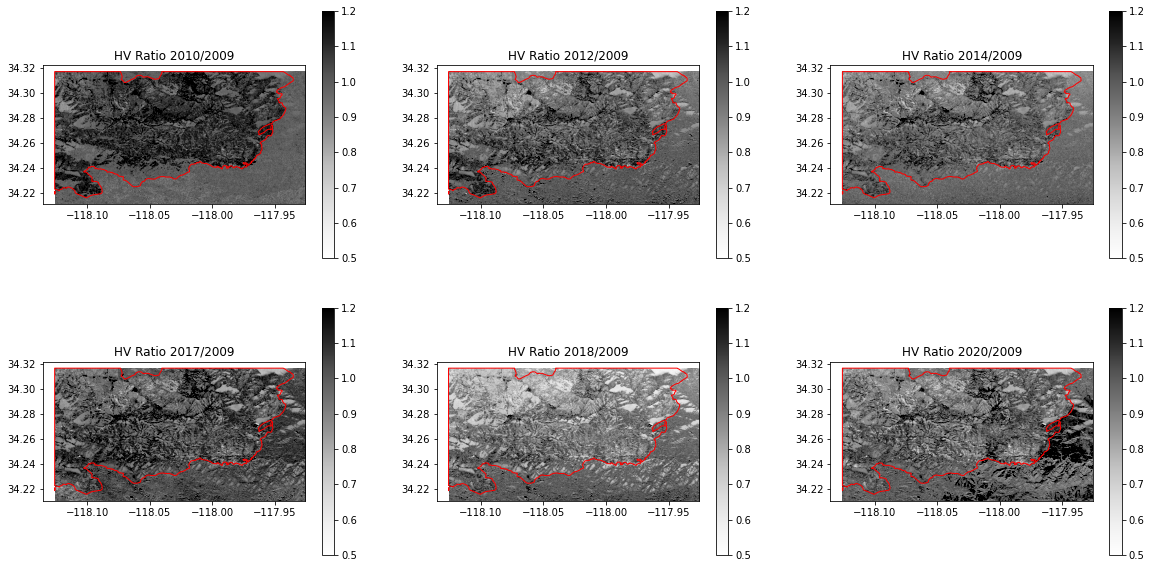

In [26]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20, 10))

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax1)
ax1.autoscale(False)
ratio_2009_2010_plot = ax1.imshow(ratio_2009_2010, vmin=0.5, vmax=1.2, cmap="Greys", extent=extent_mat)
ax1.set_title('HV Ratio 2010/2009')
fig.colorbar(ratio_2009_2010_plot, ax=ax1)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax2)
ax2.autoscale(False)
ratio_2009_2012_plot = ax2.imshow(ratio_2009_2012, vmin=0.5, vmax=1.2, cmap="Greys", extent=extent_mat)
ax2.set_title('HV Ratio 2012/2009')
fig.colorbar(ratio_2009_2012_plot, ax=ax2)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax3)
ax3.autoscale(False)
ratio_2009_2014_plot = ax3.imshow(ratio_2009_2014, vmin=0.5, vmax=1.2, cmap="Greys", extent=extent_mat)
ax3.set_title('HV Ratio 2014/2009')
fig.colorbar(ratio_2009_2014_plot, ax=ax3)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax4)
ax4.autoscale(False)
ratio_2009_2017_plot = ax4.imshow(ratio_2009_2017, vmin=0.5, vmax=1.2, cmap="Greys", extent=extent_mat)
ax4.set_title('HV Ratio 2017/2009')
fig.colorbar(ratio_2009_2017_plot, ax=ax4)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax5)
ax5.autoscale(False)
ratio_2009_2018_plot = ax5.imshow(ratio_2009_2018, vmin=0.5, vmax=1.2, cmap="Greys", extent=extent_mat)
ax5.set_title('HV Ratio 2018/2009')
fig.colorbar(ratio_2009_2018_plot, ax=ax5)

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax6)
ax6.autoscale(False)
ratio_2009_2020_plot = ax6.imshow(ratio_2009_2020, vmin=0.5, vmax=1.2, cmap="Greys", extent=extent_mat)
ax6.set_title('HV Ratio 2020/2009')
fig.colorbar(ratio_2009_2020_plot, ax=ax6)

<a name="s3"></a>
## 3. Radar Vegetation Index (RVI)
The Radar Vegetation Index (RVI) is another method to leverage SAR data for forest monitoring. See this fact sheet by SERVIR for further information: https://servirglobal.net/Portals/0/Documents/Articles/2019_SAR_Handbook/SAR_Vegetation%20Indices_one-pager.pdf

We will use the formula: 8*HV/(HH+VV+2HV) to look at 2010, 2014, and 2020 UAVSAR acquistions of line SanAnd_08527 over the San Gabriel Mountains. 

----------------------------------------------

UAVSAR data product pages:

October 14, 2010: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08527_10072_007_101014_L090_CX_02#data

October 23, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08527_14158_001_141023_L090_CX_01#data

October 14, 2020: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08527_20029_004_201014_L090_CX_01#data

-------------------------------------------

First, fetch UAVSAR geotiffs from download link with wget. Then, read in subset geotiffs



<font color='red'> 5. Run cell below </font> 

In [10]:
HH2010 = read_file('SanAnd_08527_10072_007_101014_L090HHHH_CX_02.grd.tif')
HV2010 = read_file('SanAnd_08527_10072_007_101014_L090HVHV_CX_02.grd.tif')
VV2010 = read_file('SanAnd_08527_10072_007_101014_L090VVVV_CX_02.grd.tif')

HH2014 = read_file('SanAnd_08527_14158_001_141023_L090HHHH_CX_01.grd.tif')
HV2014 = read_file('SanAnd_08527_14158_001_141023_L090HVHV_CX_01.grd.tif')
VV2014 = read_file('SanAnd_08527_14158_001_141023_L090VVVV_CX_01.grd.tif')

HH2020 = read_file('SanAnd_08527_20029_004_201014_L090HHHH_CX_01.grd.tif')
HV2020 = read_file('SanAnd_08527_20029_004_201014_L090HVHV_CX_01.grd.tif')
VV2020 = read_file('SanAnd_08527_20029_004_201014_L090VVVV_CX_01.grd.tif')

Apply RVI formula: 8*HV/(HH+VV+2HV)


<font color='red'> 6. Run cell below </font> 

In [11]:
np.seterr(divide='ignore', invalid='ignore')

RVI_2010 = 8*HV2010/(HH2010+VV2010+2*HV2010)
RVI_2014 = 8*HV2014/(HH2014+VV2014+2*HV2014)
RVI_2020 = 8*HV2020/(HH2020+VV2020+2*HV2020)

Plot RVI images


<font color='red'> 7. Run cell below </font> 

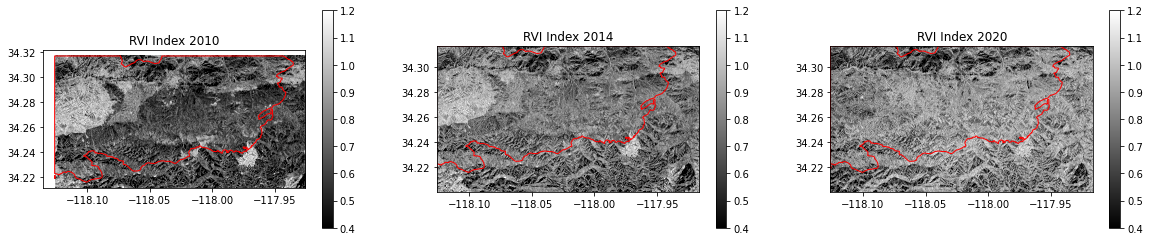

In [25]:
### Plot 2010, 2014, 2020 RVI 
fig, ax = plt.subplots(1, 3, figsize=(20,20))
fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax[0])
ax[0].autoscale(False)
RVI_2010_plt = ax[0].imshow(RVI_2010, vmin=0.4, vmax=1.2,cmap="gray", extent=extent_mat) 
ax[0].set_title('RVI Index 2010')
fig.colorbar(RVI_2010_plt, ax=ax[0], shrink=0.2) 

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax[1])
RVI_2014_plt = ax[1].imshow(RVI_2014, vmin=0.4, vmax=1.2,cmap="gray", extent=extent_mat)
ax[1].set_title('RVI Index 2014')
fig.colorbar(RVI_2014_plt, ax=ax[1], shrink=0.2) 

fire_boundary.plot(edgecolor='red', facecolor='none', ax=ax[2])
RVI_2020_plt = ax[2].imshow(RVI_2020, vmin=0.4, vmax=1.2,cmap="gray", extent=extent_mat)
ax[2].set_title('RVI Index 2020')
fig.colorbar(RVI_2020_plt, ax=ax[2], shrink=.2) 

## Other Resources

UAVSAR Data Download: https://uavsar.jpl.nasa.gov/cgi-bin/data.p

UAVSAR data product pages used in this exercise:

September 18, 2020: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_20026_016_200918_L090_CX_01#data

October 11, 2018: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_18076_003_181011_L090_CX_01#data

November 02, 2017: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_17122_003_171102_L090_CX_01#data

October 23, 2014: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_14158_003_141023_L090_CX_01#data

November 15, 2012: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_12134_001_121115_L090_CX_01#data

October 14, 2010: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_10072_005_101014_L090_CX_02#data

September 18, 2009: https://uavsar.jpl.nasa.gov/cgi-bin/product.pl?jobName=SanAnd_08525_09072_002_090918_L090_CX_02#data

--------------------------------------

## References

Marshak, C., Simard, M., Duncanson, L., Silva, C.A., Denbina, M., Liao, T.-H., Fatoyinbo, L., Moussavou, G. Armston, J. (2020). Regional Tropical Aboveground Biomass Mapping with L-Band Repeat-Pass Interferometric Radar, Sparse Lidar, and Multiscale Superpixels. Remote Sensing 12, 2048. DOI: 10.3390/rs12122048. https://www.mdpi.com/2072-4292/12/12/2048/htm


SERVIR SAR Handbook: SAR Vegetation Indices. https://servirglobal.net/Portals/0/Documents/Articles/2019_SAR_Handbook/SAR_Vegetation%20Indices_one-pager.pdf

Yu, Y., & Saatchi, S. (2016). Sensitivity of L-Band SAR Backscatter to Aboveground Biomass of Global Forests. Remote Sensing, 8(6), 522. doi:10.3390/rs8060522

Earth Observatory: https://earthobservatory.nasa.gov/images/147872/a-mosaic-of-fire-data

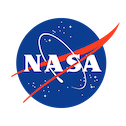

The research was carried out at the Jet Propulsion Laboratory, California Institute of Technology, under a contract with the National Aeronautics and Space Administration (80NM0018D0004)

© 2020. California Institute of Technology. Government sponsorship acknowledged. 